In [33]:
text ='Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in "memory" about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each characters appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'

Training with sequence length: 10
Epoch: 1, Train Loss: 3.1077, Train Accuracy: 0.1415, Val Loss: 2.8573, Val Accuracy: 0.1855, Duration: 1.44s
Epoch: 2, Train Loss: 2.7534, Train Accuracy: 0.2098, Val Loss: 2.6392, Val Accuracy: 0.2028, Duration: 0.82s
Epoch: 3, Train Loss: 2.5843, Train Accuracy: 0.2518, Val Loss: 2.5169, Val Accuracy: 0.2420, Duration: 0.87s
Epoch: 4, Train Loss: 2.5264, Train Accuracy: 0.2465, Val Loss: 2.4571, Val Accuracy: 0.2427, Duration: 0.86s
Epoch: 5, Train Loss: 2.4657, Train Accuracy: 0.2481, Val Loss: 2.3945, Val Accuracy: 0.2657, Duration: 0.86s
Epoch: 6, Train Loss: 2.4696, Train Accuracy: 0.2393, Val Loss: 2.3679, Val Accuracy: 0.2476, Duration: 0.83s
Epoch: 7, Train Loss: 2.4125, Train Accuracy: 0.2564, Val Loss: 2.3046, Val Accuracy: 0.2737, Duration: 0.85s
Epoch: 8, Train Loss: 2.3753, Train Accuracy: 0.2551, Val Loss: 2.2836, Val Accuracy: 0.2835, Duration: 0.82s
Epoch: 9, Train Loss: 2.3454, Train Accuracy: 0.2674, Val Loss: 2.2871, Val Accuracy: 

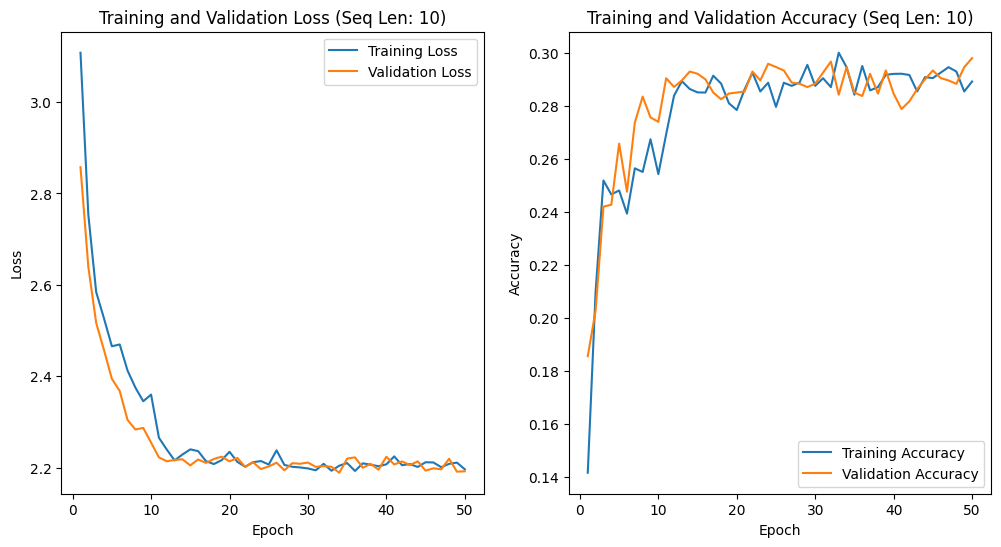

Training with sequence length: 20
Epoch: 1, Train Loss: 3.0092, Train Accuracy: 0.1696, Val Loss: 2.6962, Val Accuracy: 0.2054, Duration: 0.91s
Epoch: 2, Train Loss: 2.6534, Train Accuracy: 0.2310, Val Loss: 2.5677, Val Accuracy: 0.2472, Duration: 0.95s
Epoch: 3, Train Loss: 2.5542, Train Accuracy: 0.2453, Val Loss: 2.4730, Val Accuracy: 0.2554, Duration: 0.90s
Epoch: 4, Train Loss: 2.5038, Train Accuracy: 0.2406, Val Loss: 2.4485, Val Accuracy: 0.2478, Duration: 0.91s
Epoch: 5, Train Loss: 2.4603, Train Accuracy: 0.2537, Val Loss: 2.3497, Val Accuracy: 0.2672, Duration: 0.92s
Epoch: 6, Train Loss: 2.4132, Train Accuracy: 0.2474, Val Loss: 2.3245, Val Accuracy: 0.2652, Duration: 0.93s
Epoch: 7, Train Loss: 2.3998, Train Accuracy: 0.2579, Val Loss: 2.3396, Val Accuracy: 0.2732, Duration: 0.91s
Epoch: 8, Train Loss: 2.3683, Train Accuracy: 0.2558, Val Loss: 2.2982, Val Accuracy: 0.2608, Duration: 0.90s
Epoch: 9, Train Loss: 2.3502, Train Accuracy: 0.2564, Val Loss: 2.2802, Val Accuracy: 

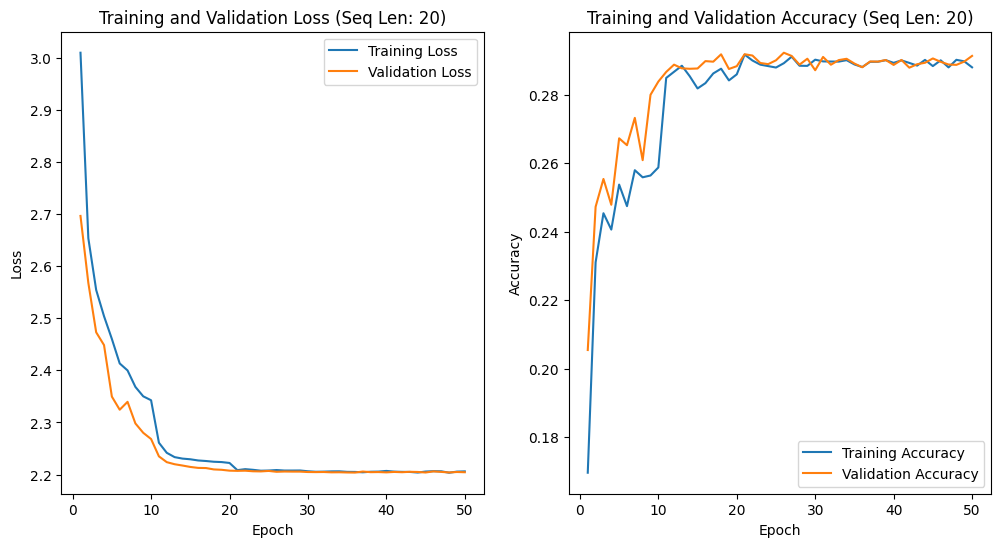

Training with sequence length: 30
Epoch: 1, Train Loss: 2.9837, Train Accuracy: 0.1655, Val Loss: 2.6466, Val Accuracy: 0.2312, Duration: 1.20s
Epoch: 2, Train Loss: 2.6270, Train Accuracy: 0.2293, Val Loss: 2.5474, Val Accuracy: 0.2546, Duration: 1.19s
Epoch: 3, Train Loss: 2.5468, Train Accuracy: 0.2479, Val Loss: 2.4492, Val Accuracy: 0.2604, Duration: 1.19s
Epoch: 4, Train Loss: 2.4936, Train Accuracy: 0.2490, Val Loss: 2.3986, Val Accuracy: 0.2635, Duration: 1.23s
Epoch: 5, Train Loss: 2.4675, Train Accuracy: 0.2407, Val Loss: 2.3783, Val Accuracy: 0.2568, Duration: 1.19s
Epoch: 6, Train Loss: 2.3977, Train Accuracy: 0.2479, Val Loss: 2.3392, Val Accuracy: 0.2654, Duration: 1.19s
Epoch: 7, Train Loss: 2.3835, Train Accuracy: 0.2650, Val Loss: 2.2947, Val Accuracy: 0.2793, Duration: 1.19s
Epoch: 8, Train Loss: 2.3552, Train Accuracy: 0.2573, Val Loss: 2.2928, Val Accuracy: 0.2756, Duration: 1.18s
Epoch: 9, Train Loss: 2.3418, Train Accuracy: 0.2646, Val Loss: 2.2908, Val Accuracy: 

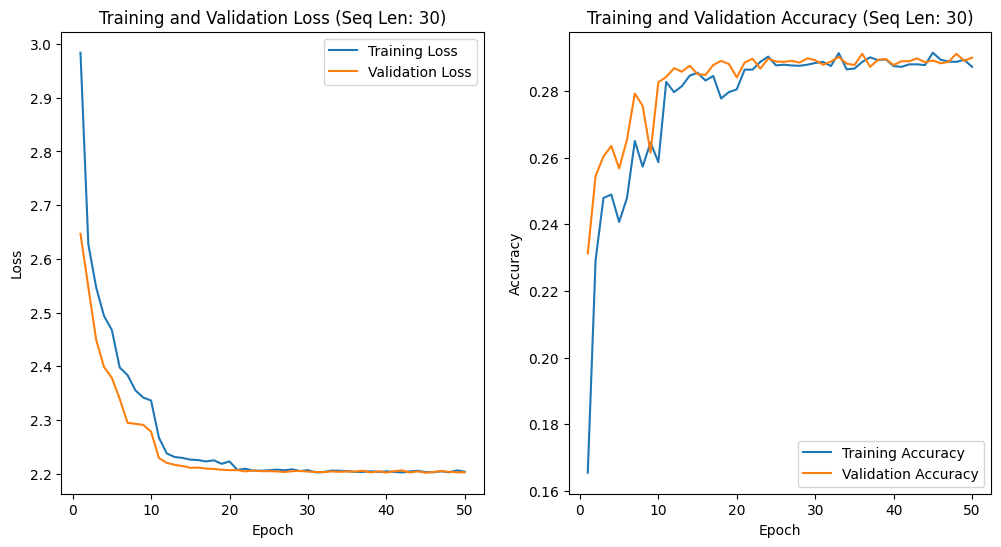

Overall accuracy for sequence length 10: 0.2980
Overall accuracy for sequence length 20: 0.2913
Overall accuracy for sequence length 30: 0.2901
Predicted next character for input of length 10: 'n'
Predicted next character for input of length 20: 'n'
Predicted next character for input of length 30: 'n'


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt

# Create character mapping
chars = sorted(set(text))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Helper function to create input and target sequences
def create_sequences(text, seq_length):
    inputs = []
    targets = []
    for i in range(len(text) - seq_length):
        input_seq = text[i:i + seq_length]
        target_char = text[i + seq_length]
        inputs.append([char_to_ix[ch] for ch in input_seq])
        targets.append(char_to_ix[target_char])
    return torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

# Incorporate Positional Encoding in CharTransformer
class CharTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, nhead, num_layers, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size  # Store hidden_size as an instance variable
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, dropout=dropout),
            num_layers)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, src):
        embedded = self.embedding(src) * np.sqrt(self.hidden_size)  # Use self.hidden_size here
        embedded = self.pos_encoder(embedded)
        transformer_output = self.transformer_encoder(embedded)
        return self.fc_out(transformer_output[:, -1])

# Training and evaluation function
def train_and_evaluate(model, data_loader, criterion, optimizer, scheduler, device, clip):
    model.to(device)
    model.train()
    total_loss = 0
    total_accuracy = 0  # Track total accuracy
    start_time = time.time()

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += (output.argmax(1) == targets).float().mean().item()

    # Adjust the learning rate
    scheduler.step()
    duration = time.time() - start_time
    total_accuracy /= len(data_loader)  # Calculate mean accuracy over all batches

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            val_loss += criterion(output, targets).item()
            val_accuracy += (output.argmax(1) == targets).float().mean().item()

    val_loss /= len(data_loader)
    val_accuracy /= len(data_loader)
    return total_loss / len(data_loader), total_accuracy, val_loss, val_accuracy, duration

def predict_next_char(model, initial_str, seq_length, char_to_ix, ix_to_char):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Adjust the input string to the expected sequence length
        initial_str = initial_str[-seq_length:]  # Keep only the last `seq_length` characters
        if len(initial_str) < seq_length:
            initial_str = (' ' * (seq_length - len(initial_str))) + initial_str  # Pad with spaces if too short
        # Convert string to a tensor
        input_tensor = torch.tensor([char_to_ix[c] for c in initial_str], dtype=torch.long).unsqueeze(0).to(device)
        # Get output from model
        output = model(input_tensor)
        # Convert output probabilities to predicted character index
        predicted_index = output.argmax(1).item()
        # Convert index to character
        predicted_char = ix_to_char[predicted_index]
        return predicted_char

# Prepare data for different sequence lengths
sequence_lengths = [10, 20, 30]
results = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {}  # Dictionary to store models

# Train and save models
for seq_length in sequence_lengths:
    print(f"Training with sequence length: {seq_length}")
    inputs, targets = create_sequences(text, seq_length)
    dataset = TensorDataset(inputs, targets)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    model = CharTransformer(len(chars), 256, 8, 6, dropout=0.001).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    clip = 1.0

    epochs = 50  # Assuming a specific number of epochs
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        train_loss, train_accuracy, val_loss, val_accuracy, duration = train_and_evaluate(
            model, data_loader, criterion, optimizer, scheduler, device, clip)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Duration: {duration:.2f}s")

    # Save model
    torch.save(model.state_dict(), f'model_{seq_length}.pth')
    print(f"Model for sequence length {seq_length} saved to disk.")
    models[seq_length] = model  # Store the model in the dictionary after training

    results[seq_length] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

    # Plotting training and validation metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss (Seq Len: {seq_length})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Seq Len: {seq_length})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
# Print overall accuracy for each sequence length
for seq_length in sequence_lengths:
    print(f"Overall accuracy for sequence length {seq_length}: "
          f"{results[seq_length]['val_accuracies'][-1]:.4f}")
    

# Prediction after loading models
test_input = "Next character predictio"

for seq_length in sequence_lengths:
    model = CharTransformer(len(chars), 256, 8, 6, dropout=0.001).to(device)
    model.load_state_dict(torch.load(f'model_{seq_length}.pth'))
    model.eval()

    predicted_character = predict_next_char(model, test_input, seq_length, char_to_ix, ix_to_char)
    print(f"Predicted next character for input of length {seq_length}: '{predicted_character}'")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import requests
import math
import time
import matplotlib.pyplot as plt


# Load data from a URL if needed
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

# Character mapping
chars = sorted(set(text))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

# Helper function to create input and target sequences
def create_sequences(text, seq_length):
    inputs = []
    targets = []
    for i in range(len(text) - seq_length):
        input_seq = text[i:i + seq_length]
        target_char = text[i + seq_length]
        inputs.append([char_to_ix[ch] for ch in input_seq])
        targets.append(char_to_ix[target_char])
    return torch.tensor(inputs, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

# # Data Preparation
# def char_tensor(string):
#     tensor = torch.zeros(len(string)).long()
#     for c in range(len(string)):
#         tensor[c] = char_to_int[string[c]]
#     return tensor

# def batchify(data, batch_size, seq_length):
#     # Cut off any data that won't fit into a fixed size
#     nbatch = data.size(0) // (batch_size * seq_length)
#     # Trim off any extra elements that wouldn't cleanly fit (remainders).
#     data = data.narrow(0, 0, nbatch * batch_size * seq_length)
#     # Evenly divide the data across the batch_size batches.
#     data = data.view(batch_size, -1).t().contiguous()
#     return data.to(device)
# 
# # Prepare the data
# data = char_tensor(text)
# BATCH_SIZE = 100
# SEQ_LENGTH = [20,30]
# # train_data = batchify(data, BATCH_SIZE, SEQ_LENGTH)

# Positional Encoding Class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Define the Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.transformer = nn.Transformer(ninp, nhead, nlayers, nhid, dropout=dropout)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer(src, src, src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Training and Evaluation Functions
# # ntokens = vocab_size  # Correct use of vocabulary size
# emsize = 200  # Embedding dimension
# nhid = 200    # Dimension of the feedforward network model in nn.TransformerEncoder
# nlayers = 2   # Number of nn.TransformerEncoderLayer in nn.TransformerEncoder
# nhead = 2     # Number of heads in the multiheadattention models
# dropout = 0.2  # Dropout value

# Initialize model, loss, optimizer, and scheduler
model = TransformerModel(vocab_size, 200, 2, 200, 2, dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def get_batch(source, i, seq_len):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

def accuracy(output, targets):
    preds = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct = preds.eq(targets.view_as(preds)).sum().item()
    return correct / len(targets)

def train(model, train_data, criterion, optimizer, scheduler, ntokens, device, seq_len):
    model.train()
    total_loss = 0.
    total_correct = 0
    total_elements = 0
    start_time = time.time()

    for i in range(0, train_data.size(0) - seq_len, seq_len):
        data, targets = get_batch(train_data, i, seq_len)
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output = model(data, model._generate_square_subsequent_mask(data.size(0)).to(device))
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        total_correct += accuracy(output.view(-1, ntokens), targets) * len(targets)
        total_elements += len(targets)

    return total_loss / (i + 1), total_correct / total_elements

def evaluate(eval_model, data_source, criterion, ntokens, device, seq_len):
    eval_model.eval()
    total_loss = 0.
    total_correct = 0
    total_elements = 0

    with torch.no_grad():
        for i in range(0, data_source.size(0) - seq_len, seq_len):
            data, targets = get_batch(data_source, i, seq_len)
            data = data.to(device)
            targets = targets.to(device)

            output = eval_model(data, eval_model._generate_square_subsequent_mask(data.size(0)).to(device))
            loss = criterion(output.view(-1, ntokens), targets)
            total_loss += len(data) * loss.item()
            total_correct += accuracy(output.view(-1, ntokens), targets) * len(targets)
            total_elements += len(targets)

    return total_loss / total_elements, total_correct / total_elements

# def train_and_evaluate(SEQ_LENGTH):
#     # Prepare the data for the specified sequence length
#     train_data = batchify(data, BATCH_SIZE, SEQ_LENGTH)
# 
#     train_losses = []
#     val_losses = []
#     train_accuracies = []
#     val_accuracies = []
# 
#     # Create a new model instance for each sequence length training
#     model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
#     optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
# 
#     # for epoch in range(1, epochs + 1):
#     #     epoch_start_time = time.time()
#     #     train_loss, train_acc = train(model, train_data, criterion, optimizer, scheduler, ntokens, device, seq_length)
#     #     val_loss, val_acc = evaluate(model, train_data, criterion, ntokens, device, seq_length) 
#     #     epoch_duration = time.time() - epoch_start_time
#     # 
#     #     train_losses.append(train_loss)
#     #     val_losses.append(val_loss)
#     #     train_accuracies.append(train_acc)
#     #     val_accuracies.append(val_acc)
#     # 
#     #     print(f"Seq Length: {seq_length}, Epoch: {epoch:2d}, "
#     #           f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
#     #           f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, "
#     #           f"Duration: {epoch_duration:.2f}s")
#     # 
#     #     scheduler.step()
#     # 
#     # return train_losses, val_losses, train_accuracies, val_accuracies
# 
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []
# epochs = 50

# for epoch in range(1, epochs + 1):
#     epoch_start_time = time.time()
#     train_loss, train_acc = train(model, train_data, criterion, optimizer, scheduler, ntokens, device)
#     val_loss, val_acc = evaluate(model, train_data, criterion, ntokens, device)  # Replace with actual validation data if available
#     epoch_duration = time.time() - epoch_start_time
# 
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     train_accuracies.append(train_acc)
#     val_accuracies.append(val_acc)
# 
#     # Printing results in a formatted way
#     print(f"Epoch: {epoch:2d}, "
#           f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
#           f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, "
#           f"Duration: {epoch_duration:.2f}s")
# scheduler.step()

def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Training and Validation Accuracy')
    plt.legend()

    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {}  # Dictionary to store models
sequence_lengths = [20, 30, 50]
results = {}

# Train and save models for each sequence length
for seq_length in sequence_lengths:
    print(f"Training with sequence length: {seq_length}")
    inputs, targets = create_sequences(text, seq_length)
    dataset = TensorDataset(inputs, targets)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    model = CharTransformer(len(chars), 256, 8, 6, dropout=0.001).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    clip = 1.0

    epochs = 50  # Assuming a specific number of epochs
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        train_loss, train_accuracy, val_loss, val_accuracy, duration = train_and_evaluate(
            model, data_loader, criterion, optimizer, scheduler, device, clip)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Duration: {duration:.2f}s")

    torch.save(model.state_dict(), f'model_{seq_length}.pth')
    models[seq_length] = model  # Store the model in the dictionary after training

    results[seq_length] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# Load models and predict the next character for "We are accounted poor citi"
test_input = "We are accounted poor citi"
for seq_length in sequence_lengths:
    model = CharTransformer(len(chars), 256, 8, 6, dropout=0.001).to(device)
    model.load_state_dict(torch.load(f'model_{seq_length}.pth'))
    model.eval()

    predicted_character = predict_next_char(model, test_input, seq_length, char_to_ix, ix_to_char)
    print(f"Predicted next character for '{test_input}' with input of length {seq_length}: '{predicted_character}'")


Training with sequence length: 20


In [38]:
    english_to_french = [

    ("I am cold", "J'ai froid"),

    ("You are tired", "Tu es fatigué"),

    ("He is hungry", "Il a faim"),

    ("She is happy", "Elle est heureuse"),

    ("We are friends", "Nous sommes amis"),

    ("They are students", "Ils sont étudiants"),

    ("The cat is sleeping", "Le chat dort"),

    ("The sun is shining", "Le soleil brille"),

    ("We love music", "Nous aimons la musique"),

    ("She speaks French fluently", "Elle parle français couramment"),

    ("He enjoys reading books", "Il aime lire des livres"),

    ("They play soccer every weekend", "Ils jouent au football chaque week-end"),

    ("The movie starts at 7 PM", "Le film commence à 19 heures"),

    ("She wears a red dress", "Elle porte une robe rouge"),

    ("We cook dinner together", "Nous cuisinons le dîner ensemble"),

    ("He drives a blue car", "Il conduit une voiture bleue"),

    ("They visit museums often", "Ils visitent souvent des musées"),

    ("The restaurant serves delicious food", "Le restaurant sert une délicieuse cuisine"),

    ("She studies mathematics at university", "Elle étudie les mathématiques à l'université"),

    ("We watch movies on Fridays", "Nous regardons des films le vendredi"),

    ("He listens to music while jogging", "Il écoute de la musique en faisant du jogging"),

    ("They travel around the world", "Ils voyagent autour du monde"),

    ("The book is on the table", "Le livre est sur la table"),

    ("She dances gracefully", "Elle danse avec grâce"),

    ("We celebrate birthdays with cake", "Nous célébrons les anniversaires avec un gâteau"),

    ("He works hard every day", "Il travaille dur tous les jours"),

    ("They speak different languages", "Ils parlent différentes langues"),

    ("The flowers bloom in spring", "Les fleurs fleurissent au printemps"),

    ("She writes poetry in her free time", "Elle écrit de la poésie pendant son temps libre"),

    ("We learn something new every day", "Nous apprenons quelque chose de nouveau chaque jour"),

    ("The dog barks loudly", "Le chien aboie bruyamment"),

    ("He sings beautifully", "Il chante magnifiquement"),

    ("They swim in the pool", "Ils nagent dans la piscine"),

    ("The birds chirp in the morning", "Les oiseaux gazouillent le matin"),

    ("She teaches English at school", "Elle enseigne l'anglais à l'école"),

    ("We eat breakfast together", "Nous prenons le petit déjeuner ensemble"),

    ("He paints landscapes", "Il peint des paysages"),

    ("They laugh at the joke", "Ils rient de la blague"),

    ("The clock ticks loudly", "L'horloge tic-tac bruyamment"),

    ("She runs in the park", "Elle court dans le parc"),

    ("We travel by train", "Nous voyageons en train"),

    ("He writes a letter", "Il écrit une lettre"),

    ("They read books at the library", "Ils lisent des livres à la bibliothèque"),

    ("The baby cries", "Le bébé pleure"),

    ("She studies hard for exams", "Elle étudie dur pour les examens"),

    ("We plant flowers in the garden", "Nous plantons des fleurs dans le jardin"),

    ("He fixes the car", "Il répare la voiture"),

    ("They drink coffee in the morning", "Ils boivent du café le matin"),

    ("The sun sets in the evening", "Le soleil se couche le soir"),

    ("She dances at the party", "Elle danse à la fête"),

    ("We play music at the concert", "Nous jouons de la musique au concert"),

    ("He cooks dinner for his family", "Il cuisine le dîner pour sa famille"),

    ("They study French grammar", "Ils étudient la grammaire française"),

    ("The rain falls gently", "La pluie tombe doucement"),

    ("She sings a song", "Elle chante une chanson"),

    ("We watch a movie together", "Nous regardons un film ensemble"),

    ("He sleeps deeply", "Il dort profondément"),

    ("They travel to Paris", "Ils voyagent à Paris"),

    ("The children play in the park", "Les enfants jouent dans le parc"),

    ("She walks along the beach", "Elle se promène le long de la plage"),

    ("We talk on the phone", "Nous parlons au téléphone"),

    ("He waits for the bus", "Il attend le bus"),

    ("They visit the Eiffel Tower", "Ils visitent la tour Eiffel"),

    ("The stars twinkle at night", "Les étoiles scintillent la nuit"),

    ("She dreams of flying", "Elle rêve de voler"),

    ("We work in the office", "Nous travaillons au bureau"),

    ("He studies history", "Il étudie l'histoire"),

    ("They listen to the radio", "Ils écoutent la radio"),

    ("The wind blows gently", "Le vent souffle doucement"),

    ("She swims in the ocean", "Elle nage dans l'océan"),

    ("We dance at the wedding", "Nous dansons au mariage"),

    ("He climbs the mountain", "Il gravit la montagne"),

    ("They hike in the forest", "Ils font de la randonnée dans la forêt"),

    ("The cat meows loudly", "Le chat miaule bruyamment"),

    ("She paints a picture", "Elle peint un tableau"),

    ("We build a sandcastle", "Nous construisons un château de sable"),

    ("He sings in the choir", "Il chante dans le chœur")

]

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random

# Define the dataset class
class TranslationDataset(Dataset):
    def __init__(self, data, src_vocab, trg_vocab):
        self.data = data
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, trg = self.data[idx]
        src_indices = [self.src_vocab[token] for token in src.split()] + [self.src_vocab["<eos>"]]
        trg_indices = [self.trg_vocab[token] for token in trg.split()] + [self.trg_vocab["<eos>"]]
        return torch.tensor(src_indices), torch.tensor(trg_indices)
    
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for src_item, trg_item in batch:
        src_batch.append(torch.cat([torch.tensor([src_vocab["<bos>"]]), src_item, torch.tensor([src_vocab["<eos>"]])], dim=0))
        trg_batch.append(torch.cat([torch.tensor([trg_vocab["<bos>"]]), trg_item, torch.tensor([trg_vocab["<eos>"]])], dim=0))
    
    src_batch = pad_sequence(src_batch, padding_value=src_vocab["<pad>"], batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=trg_vocab["<pad>"], batch_first=True)
    return src_batch, trg_batch

# Vocabulary mapping
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.count = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.count
            self.idx2word[self.count] = word
            self.count += 1

    def __getitem__(self, word):
        return self.word2idx.get(word, self.word2idx["<unk>"])

    def __len__(self):
        return self.count

# Create vocabularies
def create_vocabularies(data):
    src_vocab = Vocabulary()
    trg_vocab = Vocabulary()
    special_tokens = ["<pad>", "<unk>", "<bos>", "<eos>"]

    for token in special_tokens:
        src_vocab.add_word(token)
        trg_vocab.add_word(token)

    for src, trg in data:
        for word in src.split():
            src_vocab.add_word(word)
        for word in trg.split():
            trg_vocab.add_word(word)
    return src_vocab, trg_vocab


src_vocab, trg_vocab = create_vocabularies(english_to_french)
dataset = TranslationDataset(english_to_french, src_vocab, trg_vocab)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)


# Transformer model
class TransformerModel(nn.Module):
    def __init__(self, num_tokens, d_model=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        self.embedding = nn.Embedding(num_tokens, d_model)
        self.output_layer = nn.Linear(d_model, num_tokens)
        self.d_model = d_model

    def forward(self, src, trg, src_mask=None, trg_mask=None):
        src = self.embedding(src) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        trg = self.embedding(trg) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        output = self.transformer(src, trg, src_key_padding_mask=src_mask, tgt_key_padding_mask=trg_mask)
        return self.output_layer(output)

# Training loop
def train(model, dataloader, optimizer, criterion, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for src, trg in dataloader:
            print(f"Source shape: {src.shape}, Target shape: {trg.shape}")  # Debug statement
            src, trg = src.transpose(0,1), trg.transpose(0,1)  # Batch first to Time first
            print(f"Transposed Source shape: {src.shape}, Transposed Target shape: {trg.shape}")  # Debug statement
            optimizer.zero_grad()
            output = model(src, trg[:-1])
            print(f"Output shape: {output.shape}")  # Debug statement
            loss = criterion(output.view(-1, output.size(-1)), trg[1:].reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

# Initialize model and train
model = TransformerModel(num_tokens=len(src_vocab))
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index=src_vocab["<pad>"])

train(model, dataloader, optimizer, criterion)


Source shape: torch.Size([2, 6]), Target shape: torch.Size([2, 6])
Transposed Source shape: torch.Size([6, 2]), Transposed Target shape: torch.Size([6, 2])
Output shape: torch.Size([5, 2, 188])
Source shape: torch.Size([2, 9]), Target shape: torch.Size([2, 9])
Transposed Source shape: torch.Size([9, 2]), Transposed Target shape: torch.Size([9, 2])
Output shape: torch.Size([8, 2, 188])
Source shape: torch.Size([2, 7]), Target shape: torch.Size([2, 7])
Transposed Source shape: torch.Size([7, 2]), Transposed Target shape: torch.Size([7, 2])


IndexError: index out of range in self